# Lab 2 Simulation
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class Cart_and_mass:
    def __init__(self, Y, w, theta, length=1) -> None:
        # Parameters
        self.mass = 1           # kg
        self.length = length    # bar length
        self.gravity = 9.8      # m/s^2
        self.amplitude = Y  # y(t) = Y*sin(w*t)
        self.omega = w      #        ^     ^
        # Initial state
        self.time = 0
        self.cart_y = 0     # cart position (initial: y=0)
        self.theta = theta  # bar angle (y-axis --> bar)
        self.theta_dot = 0
        self.p_x = 0    # mass momentum in the x-direction
        self.p_y = 0    # mass momentum in the y-direction (unused)
        self.mass_x = self.length*np.cos(self.theta) # UNUSED position data
        self.mass_y = self.length*np.sin(self.theta) # UNUSED position data
        # States
        self.history = [self.get_state()]   # use to store simulation data (states and observables)
        self.history_desc = "[cart_y, theta, theta_dot, p_x, time]"
        self.observable = [self.get_observables]
    
    def get_state(self)->list:
        return [
            self.cart_y,
            self.theta,
            self.theta_dot,
            self.p_x,
            self.time
        ]
    def get_observables(self)->list:
        return [
            self.cart_y,
            self.theta,
            self.theta_dot,
            self.p_x,
            self.p_y,
            self.mass_x,
            self.mass_y,
            self.time,
        ]
    
    def get_cart_position(self, time=None):
        if time==None:
            time = self.time
        return self.amplitude*np.sin(self.omega*time)
    def get_cart_velocity(self, time=None):
        if time==None:
            time = self.time
        return self.amplitude*self.omega*np.cos(self.omega*time)
    def get_cart_acceleration(self, time=None):
        if time==None:
            time = self.time
        return -(self.omega**2)*self.amplitude*np.sin(self.omega*time) # -(w^2)Ysin(wt)
    
    def calc_Px_dot(self, cart_acceleration, theta, theta_dot, P_x):
        '''
        Formula (4) from the lab pdf. Must provide the function parameters
        '''
        term1 = self.mass*self.gravity*np.sin(theta)*np.cos(theta)
        term2 = self.mass*cart_acceleration*np.sin(theta)*np.cos(theta)
        term3 = (np.sin(theta)/np.cos(theta))*theta_dot*P_x
        return term1 + term2 - term3    # subtracting term3, see eq (4) in the pdf
    def calc_Py_dot(self, cart_acceleration, theta, theta_dot, P_x):
        '''
        Formula (2)
        '''
        P_x_dot = self.calc_Px_dot(
            cart_acceleration=cart_acceleration,
            theta=theta,
            theta_dot=theta_dot,
            P_x=P_x
            )
        #terms inside parentheses
        term1 = cart_acceleration
        term2 = (np.sin(theta)/np.cos(theta))*(P_x_dot/self.mass)
        term3 = (P_x/self.mass)*(theta_dot/(np.cos(theta)**2))
        return self.mass*(term1 - term2 - term3)
    def calc_theta_dot(self, theta, P_x):
        '''
        Equation (5)
        '''
        return (1/(self.length*np.cos(theta)))*(P_x/self.mass)

    def update_observables(self):
        #update the unimportant stuff (Py, mass x&y, )
        pass

    def time_step(self, dt):
        # increment time (current state still holds "previous" values)
        cart_accel = self.get_cart_acceleration(self.time) #instantaneous acceleration
        self.time += dt
        self.cart_y = self.get_cart_position(self.time)
        # calculating forces acting on the mass
        Fx = self.calc_Px_dot(
            cart_acceleration=cart_accel,
            theta=self.theta,
            theta_dot=self.theta_dot,
            P_x=self.p_x
        )
        # inserting new values: state = [cart_y, theta, theta_dot, p_x, time]
        self.theta_dot = self.calc_theta_dot(
            theta=self.theta,
            P_x=self.p_x
            )
        self.p_x += Fx*dt  # new momentum
        self.theta += self.theta_dot*dt # updated angle
        if abs(self.theta) > np.pi*2:
            self.theta %= 2*np.pi           # constrain from 0 to 2pi
        # Updates
        self.history.append(self.get_state())
        #TODO: track observables
        return
    def reset(self):
        #TODO:return to initial state
        pass
    
    def search_time_step(self, dt):
        self.time_step(dt)
        if self.theta > np.deg2rad(90) or self.theta < np.deg2rad(-90):
            raise Exception(f"Angle out of bounds: {self.get_state()=}\n{self.history_desc}")

## Simulation

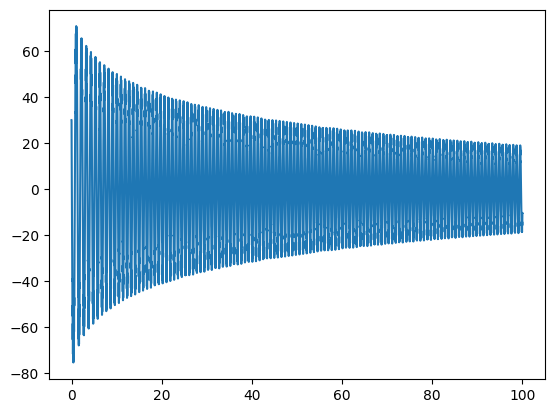

In [2]:
def deg_to_rad(deg):
    return deg*np.pi/180

# Simulation with provided parameters
y = 0.1 # m
f = 20  # Hz
sim = Cart_and_mass(
    Y=y, 
    w=2*np.pi*f, 
    theta=deg_to_rad(30), 
    length=1
    )
dt = 0.001
time_span = np.arange(0,100,dt)
for moment in time_span:
    sim.time_step(dt)
states = sim.history[:len(sim.history)]
x = [t[-1] for t in states]
y = [np.rad2deg(t[1]) for t in states]
plt.plot(x,y)

In [3]:
# Creating a phase space for simulation parameters and to score simulation stability
class Phase_space:
    def __init__(self, angles = [deg_to_rad(num) for num in [10,20,30]]):
        self.angles = angles
        self.Y_space = np.linspace(-.5, .5, 100)
        self.w_space = 2*np.pi*np.linspace(0, 100, 100)
        self.PS_times = np.array(
            [[np.zeros(len(self.w_space))]*len(self.Y_space)]*len(self.angles)
            )
# PS_times array index as follows: [i_angle, i_Y, i_w]
    def query_phase_space(self, Y_val, w_val):
        closest_indecies = []
        for i_y, val in enumerate(self.Y_space):
            if val > Y_val:
                closest_indecies.append(i_y)
                break
        for i_w, val in enumerate(self.w_space):
            if val > w_val:
                closest_indecies.append(i_w)
                break
        return closest_indecies # not accurate but good enough

def simulation(angle, amplitude, omega, time_span, dt, test=False):
    temp_sim = Cart_and_mass(
        Y=amplitude,
        w=omega,
        theta=angle
    )
    threshold = 95
    positive = (temp_sim.theta > 0)
    oscillation_count = 0
    for moment in time_span:
        temp_sim.time_step(dt)
        if positive and (temp_sim.theta < 0):
            print(moment, "oscillated to negative") if test else ""
            oscillation_count+=1
            positive = False
        elif (not positive) and (temp_sim.theta > 0):
                print(moment, "oscillated to positive") if test else ""
                positive = True
                oscillation_count+=1
        if abs(np.rad2deg(temp_sim.theta)) > threshold:
            print(moment, "Over 90 degrees") if test else ""
            return moment
    if oscillation_count < 5:
        return -1 # stable, but not around the vertical position
    return time_span[-1]

In [4]:
from joblib import Parallel, delayed
# Separated param setup to avoid overwriting data if the next cell is accidentally reran
data = Phase_space()
dt = 0.001
max_time = 10
time_span = np.arange(0, max_time, dt)
# Create list of all parameter combinations
params = []
for i_angle, angle in enumerate(data.angles):
    for i_Y, amplitude in enumerate(data.Y_space):
        for i_w, omega in enumerate(data.w_space):
            params.append((i_angle, i_Y, i_w, angle, amplitude, omega))


In [5]:
if params != []:
    print(f"Running {len(params)} simulations in parallel...")
    # Run simulations in parallel
    results = Parallel(n_jobs=-2, verbose=5)(
        delayed(simulation)(angle, amplitude, omega, time_span, dt) # creates function...
        for i_angle, i_Y, i_w, angle, amplitude, omega in params    # ...for each set of parameters
    )
    # Fill in the results matrix
    for (i_angle, i_Y, i_w, *_), time in zip(params, results):
        data.PS_times[i_angle, i_Y, i_w] = time
params = [] # prevents me from overwriting the data if I rerun this cell
print("Grid search complete!")

Running 30000 simulations in parallel...


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 228 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 732 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-2)]: Done 1380 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-2)]: Done 2172 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-2)]: Done 3108 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-2)]: Done 4188 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-2)]: Done 5412 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-2)]: Done 6780 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-2)]: Done 8292 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 9948 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 11997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 12531 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 13575 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 14691 tasks  

Grid search complete!


[Parallel(n_jobs=-2)]: Done 29971 out of 30000 | elapsed:  3.5min remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 30000 out of 30000 | elapsed:  3.5min finished


In [6]:
# Same as previous cells, but mapping the phase space for 70, 80, and 90 degrees
large_angle_data = Phase_space([deg_to_rad(num) for num in [70,80,90]])
# Searching phase space for large angles
large_angle_params = []
for i_angle, angle in enumerate(large_angle_data.angles):
    for i_Y, amplitude in enumerate(large_angle_data.Y_space):
        for i_w, omega in enumerate(large_angle_data.w_space):
            large_angle_params.append((i_angle, i_Y, i_w, angle, amplitude, omega))

In [7]:
if large_angle_params != []:
    print(f"Running {len(large_angle_params)} simulations in parallel...")
    # Run simulations in parallel
    large_angle_results = Parallel(n_jobs=-2, verbose=5)(
        delayed(simulation)(angle, amplitude, omega, time_span, dt)
        for i_angle, i_Y, i_w, angle, amplitude, omega in large_angle_params
    )
    # Fill in the results matrix
    for (i_angle, i_Y, i_w, *_), time in zip(large_angle_params, large_angle_results):
        large_angle_data.PS_times[i_angle, i_Y, i_w] = time

large_angle_params = []
print("Grid search complete!")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  54 tasks      | elapsed:    0.1s


Running 30000 simulations in parallel...


[Parallel(n_jobs=-2)]: Done 650 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 9954 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 18432 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done 22876 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done 27528 tasks      | elapsed:   20.1s


Grid search complete!


[Parallel(n_jobs=-2)]: Done 30000 out of 30000 | elapsed:   24.6s finished


## Creating Plots

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def heatmap(angle_labels = ['10°', '20°', '30°'], PS=data, title='stability_heatmaps.png'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (ax, angle_label) in enumerate(zip(axes, angle_labels)):
        # Extract the 2D slice for this angle
        time_grid = PS.PS_times[i, :, :]
        # Create heatmap
        im = ax.imshow(time_grid,
                    extent=[0, 100, -0.5, 0.5],  # [freq_min, freq_max, Y_min, Y_max]
                    aspect='auto',
                    origin='lower',
                    cmap='hot',  
                    vmin=-1,
                    vmax=10)  

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude Y [m]')
        ax.set_title(f'Initial Angle θ₀ = {angle_label}')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Time survived [s]')
    plt.tight_layout()
    plt.savefig(title, dpi=150, bbox_inches='tight')
    plt.show()
    print("Heatmap saved as 'stability_heatmaps.png'")

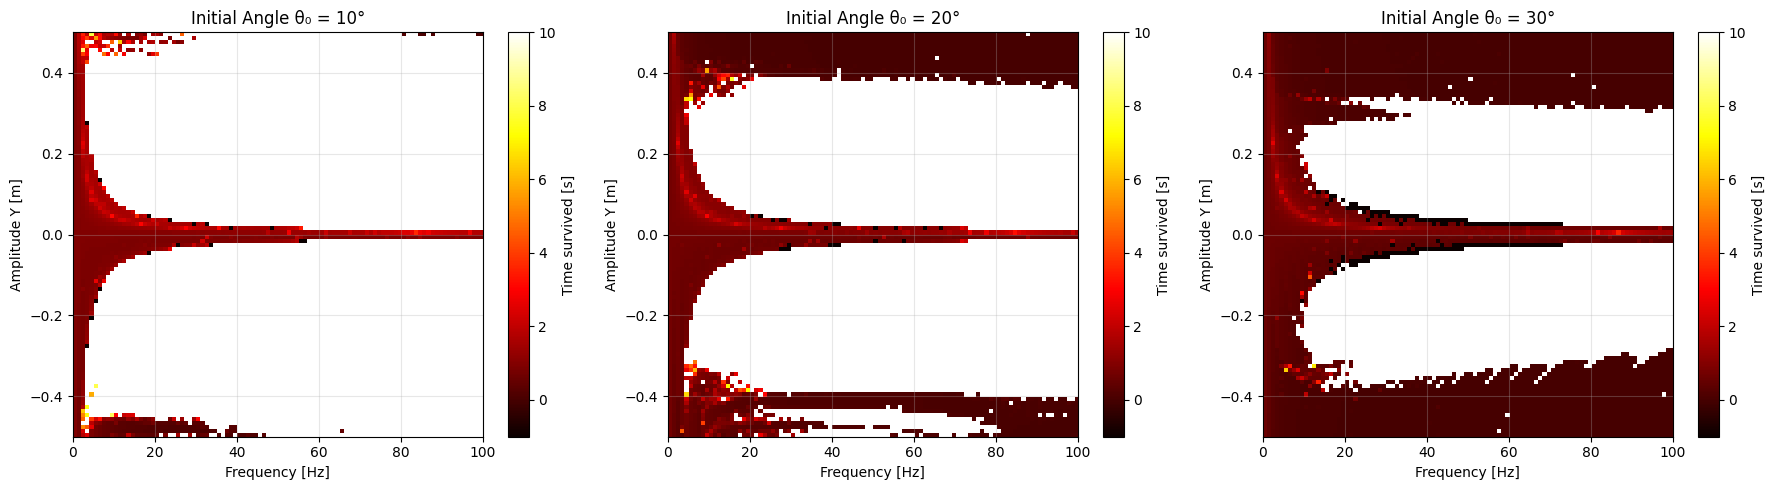

Heatmap saved as 'stability_heatmaps.png'


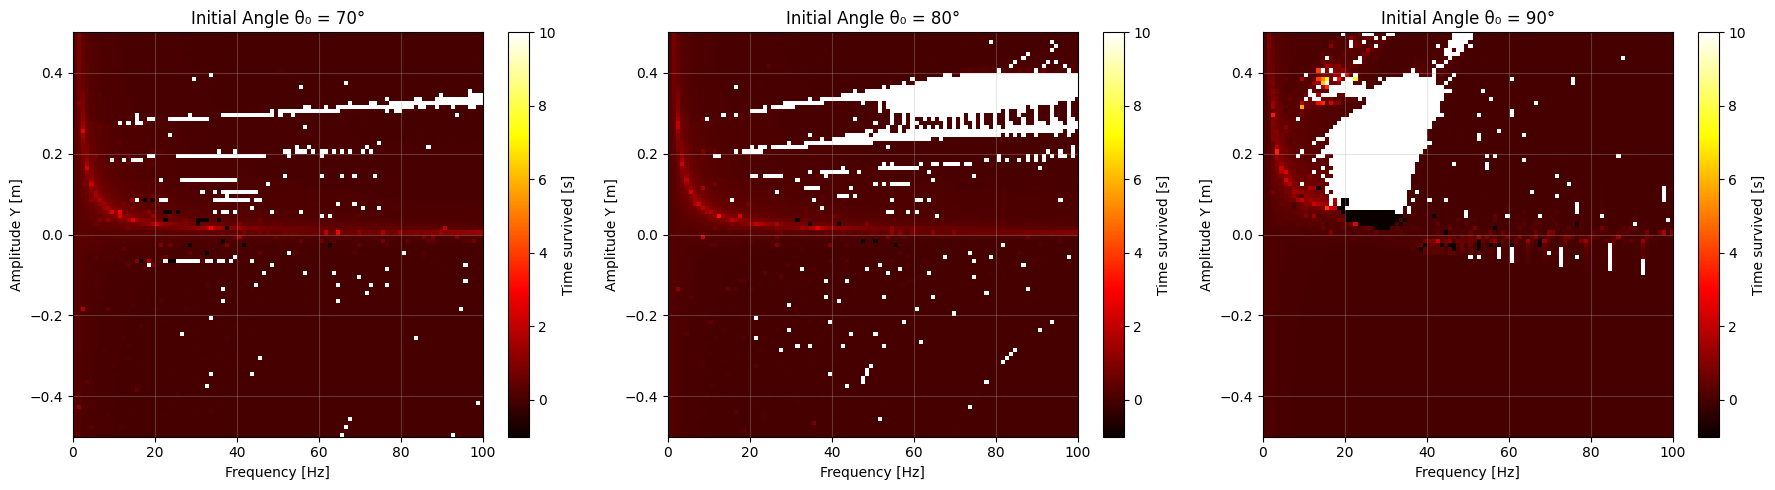

Heatmap saved as 'stability_heatmaps.png'


In [9]:
heatmap(PS=data)
heatmap(angle_labels=['70°', '80°', '90°'], PS=large_angle_data, title="large angle heatmap.png")

In [10]:
def angle_time_plot(times, angles, radians=True, fig=0, title="Angle vs Time"):
    if radians:
        angles = np.rad2deg(angles)
    plt.figure(fig)
    plt.plot(times, angles)
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Angle [degrees]")
    plt.show()

def plot_sim(Y, w, theta, time_span, dt, title="Angle vs Time", subset_ratio=1.0):
    temp_sim = Cart_and_mass(
        Y=Y,
        w=w,
        theta=theta
    )
    for moment in time_span:
        temp_sim.time_step(dt)
    states = temp_sim.history
    subset = states[:int(len(states)//(1/subset_ratio))]
    times = [state[-1] for state in subset]
    angles = [np.rad2deg(state[1]) for state in subset]

    angle_time_plot(times=times, angles=angles, radians=False, title=title)

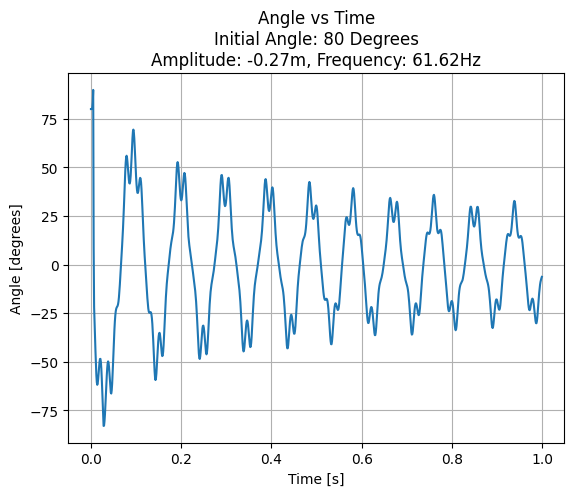

In [60]:
# Lone point on the 80 degree heat map
plot_sim(
    Y = large_angle_data.Y_space[23],
    w = large_angle_data.w_space[61],
    theta = deg_to_rad(80),
    time_span=time_span,
    dt=dt,
    title=f"Angle vs Time\nInitial Angle: 80 Degrees\nAmplitude: {large_angle_data.Y_space[23]:.2f}m, Frequency: {large_angle_data.w_space[61]/(2*np.pi):.2f}Hz",
    subset_ratio=.1,
)

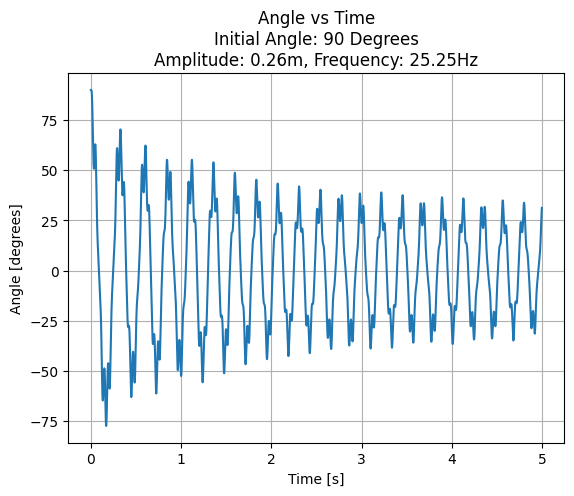

In [61]:
# Point on the 90 degree heat map
plot_sim(
    Y = large_angle_data.Y_space[75],
    w = large_angle_data.w_space[25],
    theta = deg_to_rad(90),
    time_span=time_span,
    dt=dt,
    title=f"Angle vs Time\nInitial Angle: 90 Degrees\nAmplitude: {large_angle_data.Y_space[75]:.2f}m, Frequency: {large_angle_data.w_space[25]/(2*np.pi):.2f}Hz",
    subset_ratio=.5,
)

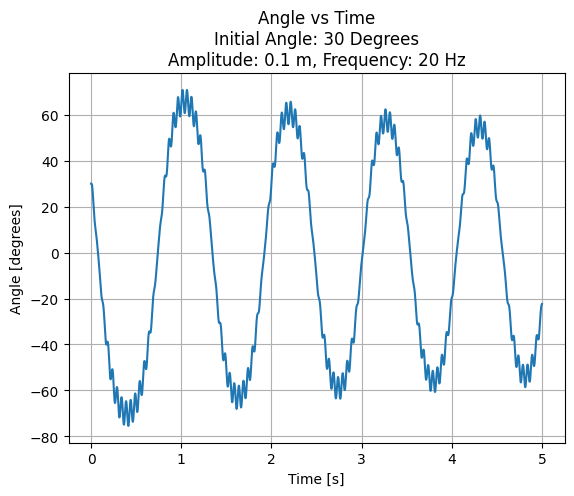

In [62]:
# Provided Parameters (Y=0.1, f=20)
plot_sim(
    Y = 0.1,
    w = 20*2*np.pi,
    theta = deg_to_rad(30),
    time_span=time_span,
    dt=dt,
    title="Angle vs Time\nInitial Angle: 30 Degrees\nAmplitude: 0.1 m, Frequency: 20 Hz",
    subset_ratio=.5,
)

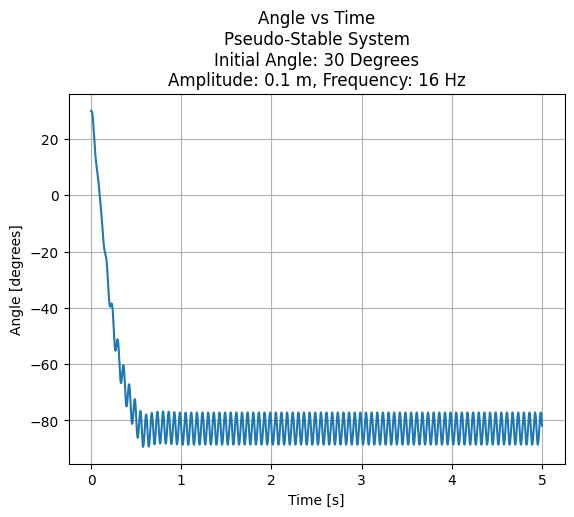

In [63]:
# Pseudo Stable System
plot_sim(
    Y = 0.1,
    w = 16*2*np.pi,
    theta = deg_to_rad(30),
    time_span=time_span,
    dt=dt,
    title="Angle vs Time\nPseudo-Stable System\nInitial Angle: 30 Degrees\nAmplitude: 0.1 m, Frequency: 16 Hz",
    subset_ratio=.5,
)